In [1]:
import cProfile
import os
import pickle
import pstats
import re
import time
from collections import namedtuple, defaultdict
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import rich.progress
import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys

import data_types
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns
from data_types import PickleOut
import commons
import rich.status
from rich.pretty import pprint
from rich import inspect
import textwrap

In [2]:
rc = commons.rc

In [3]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])
CVUBigTR = namedtuple("CVUBigTableRow", [
    "regModel",
    "cluster",
    "clusterSize",
    "wfName",
    "method",
    "res",
    #"schedCat",
    #"schedType",
    "cvSplit",
    "ukSplit"])

In [4]:
shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                      'SVR-linear'   : 'SVR - linear',
                      'SVR-poly'     : 'SVR - poly',
                      'SVR-rbf'      : 'SVR - rbf',
                      'SVR-sigmoid'  : 'SVR - sigmoid',
                      'Lasso'        : 'Lasso',
                      'LassoCV'      : 'Lasso CV',
                      'Ridge'        : 'Ridge',
                      'RidgeCV'      : 'Ridge CV',
                      'ElasticNet'   : 'Elastic Net',
                      'ElasticNetCV' : 'Elastic Net CV',
                      'BayesianRidge': 'Bayesian Ridge',
                      'ARD'          : 'Automatic Relevance Determination',
                      'SGD'          : 'Stochastic Gradient Descent',
                      'PA'           : 'Passive Aggressive',
                      'Huber'        : 'Huber',
                      'TheilSen'     : 'Theil Sen'}

In [5]:
def load_from_file(f, prog: rich.progress.Progress, barid):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl: dict = pickle.load(tmp)
    #
    m = re.match("(?:.*/)*(.*Model)\.(.*)_CV-(.*)_U-(.*)\.recSchedTimes\.pickle", f)
    modelDeg = modelDegLUT[m.group(1)]
    modelName = shortToLongNameLUT[m.group(2)]
    shortName = f"{modelDeg} / {modelName}"
    cvSplit = m.group(3)
    if cvSplit == "None":
        cvSplit = None
    ukSplit = m.group(4)
    if ukSplit == "None":
        ukSplit = None
    # for pre, deg in modelDegLUT.items():
    #     if pre in shortName:
    #         shortName = shortName.replace(pre + ".", f"{deg}/")
    #         break
    fmt = CVUBigTR
    #
    prog.reset(barid, total=len(pl.items()))
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : str(clusterName),
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    #"schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    #"schedType"  : mName,
                    "cvSplit"    : cvSplit,
                    "ukSplit"    : ukSplit
                }
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                # else:
                #     rowInfo["regModel"] = "N/A"
                #     rowInfo["schedCat"] = "random"
                #     rowInfo["schedType"] = "random"
                #     randomPs = [1, 2, 3]
                #     for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                #         if i + 1 in randomPs:
                #             rowInfo["method"] = mName + f"P{i * 10}"
                #             rowInfo["res"] = float(r)
                #             yield fmt(**rowInfo)
                #     rowInfo["method"] = mName + "Avg"
                #     rowInfo["res"] = float(statistics.mean(res))
                #     yield fmt(**rowInfo)
        prog.advance(barid)
    del pl


def load_random_from_files(d, prog: rich.progress.Progress, barid):
    if type(d) is str:
        d = Path(d)
    #
    refFile = d.joinpath(os.listdir(d)[0])
    with open(refFile, "br") as tmp:
        refP: dict = pickle.load(tmp)
    #
    fmt = CVUBigTR
    cls = list(refP.keys())
    wfs = list(refP[cls[0]].keys())
    del refP
    prog.reset(barid, total=len(cls) * len(wfs))
    pls = list()
    for fName in os.listdir(d):
        pFile = d.joinpath(fName)
        with open(pFile, "br") as tmp:
            pl: dict = pickle.load(tmp)
        for clusterName, cluster in pl.items():
            for wfName, wf in cluster.items():
                for methodName in list(wf.keys()):
                    if not "random" in methodName:
                        del pl[clusterName][wfName][methodName]
        #
        pls.append(pl)
        del pl
    for clusterName in cls:
        for wfName in wfs:
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            #
            randoms = [x for pl in pls for x in pl[clusterName][wfName]["randomSchedulerV1"]]
            for pl in pls:
                del pl[clusterName][wfName]
            randoms.sort()
            indices = [int(round(len(randoms) - 1 - x * (len(randoms) - 1), 0)) for x in [a / 10 for a in range(0, 11)]]
            randoms = [x for i, x in enumerate(randoms) if i in indices]
            rowInfo = {
                "regModel"   : "N/A",
                "cluster"    : str(clusterName),
                "clusterSize": len(clusterName),
                "wfName"     : wfShortName,
                "method"     : "randomV1",
                #"schedCat"   : "random",
                #"schedType"  : "random",
                "cvSplit"    : "N/A",
                "ukSplit"    : "N/A"
            }
            for i, r in enumerate(randoms):  # this only applies to the results of the randomScheduler(V1)
                rowInfo["method"] = f"randomV1P{i * 10}"
                rowInfo["res"] = float(r)
                yield fmt(**rowInfo)
            rowInfo["method"] = "randomV1Avg"
            rowInfo["res"] = float(statistics.mean(randoms))
            yield fmt(**rowInfo)
            prog.advance(barid)


def load_from_dir(d):
    with commons.stdProgress(rc) as prog:
        # with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        fileProg = prog.add_task("Files", total=len(os.listdir(d)))
        clusterProg = prog.add_task("Clusters")
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}", prog, clusterProg)
            prog.advance(fileProg)
        randomsProg = prog.add_task("Randoms")
        yield from load_random_from_files(d, prog, randomsProg)

In [6]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        bigtable = pds.DataFrame(load_from_dir(saveLoc), columns=CVUBigTR._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [7]:
def save_plot(obj, name, loc="./fig/", **kwargs):
    obj.savefig(f"{loc}{name}.pdf", transparent=True, **kwargs)
    obj.savefig(f"{loc}{name}.png", transparent=True, **kwargs)

# Get the recSchedTimes data

In [8]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# bigtable

# Get the cvRecSchedTimes data

In [ ]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

In [9]:
wfNames = bigtable.wfName.unique()

In [10]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [11]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


# trying out new visualisation

In [12]:
def getRegModelMethodScores(fileLoc: Path, table, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(cur, mini, tol):
            return abs(cur - mini) <= tol

        crit = yep
    if scorer is None:
        def sc(cur, mini, tol):
            return 1

        scorer = sc
    if type(fileLoc) is str:
        fileLoc = Path(fileLoc)
    if fileLoc.is_file():
        with open(fileLoc, "br") as f:
            return pickle.load(f)
    else:
        grouped = table[table.regModel != "N/A"].pivot(["cluster", "wfName", "regModel"], "method", "res")
        clWFCombs = itertools.product(clusters, wfNames)
        numclWFCombs = len(list(clWFCombs))
        clWFCombs = itertools.product(clusters, wfNames)
        rMMethCombs = list(itertools.product(regModels, methods))
        # regModelMethodScores = defaultdict(lambda: 0)
        with commons.stdProgress(rc) as prog:
            cvwfProg = prog.add_task("Cluster/Workflow", total=numclWFCombs)
            regModelMethodScores = defaultdict(lambda: 0)

            for clwf, subtable in grouped.groupby(level=(0, 1), group_keys=False):
                c, wf = clwf
                subtable = subtable.droplevel(["cluster", "wfName"])
                minimumTime = subtable.min().min()
                for rmmetch in rMMethCombs:
                    rM, meth = rmmetch
                    # rc.log(subtable.loc[rM, meth], minimumTime, abs(subtable.loc[rM, meth] - minimumTime), abs(subtable.loc[rM, meth] - minimumTime) <= tol)
                    curr = subtable.loc[rM, meth]
                    if type(tol) is int or type(tol) is float:
                        t = tol
                    else:
                        t = tol(curr, minimumTime)
                    if crit(curr, minimumTime, t):
                        regModelMethodScores[rmmetch] = regModelMethodScores[rmmetch] + scorer(curr, minimumTime, t)
                prog.advance(cvwfProg)
            regModelMethodScores = dict(regModelMethodScores)
        #
        with open(fileLoc, "bw") as f:
            pickle.dump(regModelMethodScores, f)
        return dict(regModelMethodScores)

------

In [13]:
tmp = bigtable[bigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [14]:
confs = dict()
with open("percentileModels", "r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l: PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle", fName.strip())
            confs[f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"] = commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])


In [15]:
confs

{
│   '5 / Ordinary Least Squares': 1.0,
│   '3 / Ridge': 0.9231538458419148,
│   ... +9
}

In [16]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [17]:
pprint(regModels)

[
│   '5 / Ordinary Least Squares',
│   '3 / Ridge',
│   '3 / SVR - linear',
│   '3 / Elastic Net CV',
│   '2 / Ridge CV',
│   '1 / Ordinary Least Squares',
│   '1 / Lasso CV',
│   '1 / SVR - linear',
│   '3 / Elastic Net',
│   '1 / Elastic Net',
│   '4 / Passive Aggressive'
]

In [18]:
regModelMethodScores = getRegModelMethodScores("regModelMethodScores.pickle", bigtable)

In [19]:
regModelMethodDiffs = getRegModelMethodScores("regModelMethodDiffs.pickle", bigtable, crit=lambda a, b, c: True, scorer=lambda cur, mini, tol: abs(cur - mini))

In [20]:
regModelMethodScores10P = getRegModelMethodScores("regModelMethodScores10P.pickle",
                                                  bigtable,
                                                  tol=lambda cur, mini: 10 * mini / 100)

In [21]:
regModelMethodScores

{
│   ('1 / Lasso CV', 'recommenderV1'): 5346,
│   ('1 / Lasso CV', 'recommenderV1H1'): 5516,
│   ... +86
}

In [22]:
regModelMethodDiffs

{
│   ('5 / Ordinary Least Squares', 'recommenderV1'): 239649005.83414665,
│   ('5 / Ordinary Least Squares', 'recommenderV1H1'): 275930202.1803047,
│   ... +86
}

In [23]:
regModelMethodScores10P

{
│   ('1 / Lasso CV', 'recommenderV1'): 35744,
│   ('1 / Lasso CV', 'recommenderV1H1'): 35850,
│   ... +86
}

-------------

In [24]:
regModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores.items():
    rM, meth = rm
    regModelMethodScoresDF.loc[rM, meth] = s

In [25]:
regModelMethodScoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,25731.0,27353.0,27353.0,28508.0,9615.0,9903.0,9903.0,9654.0
3 / Ridge,9628.0,10563.0,10563.0,11010.0,6874.0,6824.0,6824.0,6643.0
3 / SVR - linear,5818.0,6311.0,6311.0,6909.0,5492.0,5875.0,5875.0,5797.0
3 / Elastic Net CV,7031.0,6694.0,6694.0,6641.0,5087.0,5512.0,5512.0,5272.0
2 / Ridge CV,5328.0,5502.0,5502.0,5439.0,5277.0,5668.0,5668.0,5445.0
1 / Ordinary Least Squares,5369.0,5422.0,5422.0,5116.0,4605.0,5089.0,5089.0,4854.0
1 / Lasso CV,5346.0,5516.0,5516.0,5329.0,4467.0,4961.0,4961.0,4766.0
1 / SVR - linear,4731.0,5343.0,5343.0,5141.0,4179.0,4546.0,4546.0,4344.0
3 / Elastic Net,5347.0,4954.0,4954.0,4851.0,3742.0,4000.0,4000.0,3851.0
1 / Elastic Net,3789.0,4030.0,4030.0,4232.0,2613.0,2895.0,2895.0,2833.0


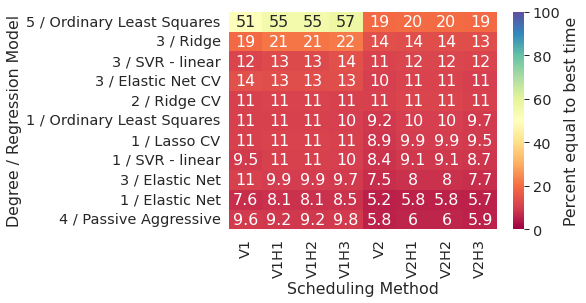

In [26]:
# normalize
total = 50_000
tmp = regModelMethodScoresDF.transform(lambda x: 100 * x / total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScoresDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmapBIS", bbox_inches="tight")
plt.show()

In [27]:
regModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores10P.items():
    rM, meth = rm
    regModelMethodScores10PDF.loc[rM, meth] = s

In [28]:
regModelMethodScores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,43509.0,43304.0,43304.0,44438.0,37449.0,36687.0,36687.0,36050.0
3 / Ridge,42956.0,42587.0,42587.0,43463.0,37101.0,35902.0,35902.0,34888.0
3 / SVR - linear,38292.0,39259.0,39259.0,40567.0,35636.0,34450.0,34450.0,33553.0
3 / Elastic Net CV,38136.0,38746.0,38746.0,39246.0,34599.0,34365.0,34365.0,32863.0
2 / Ridge CV,37002.0,38431.0,38431.0,38518.0,35209.0,35127.0,35127.0,33285.0
1 / Ordinary Least Squares,33601.0,34683.0,34683.0,34709.0,33180.0,33224.0,33224.0,31051.0
1 / Lasso CV,35744.0,35850.0,35850.0,35905.0,32357.0,32831.0,32831.0,30720.0
1 / SVR - linear,33344.0,34826.0,34826.0,34813.0,32533.0,32668.0,32668.0,30441.0
3 / Elastic Net,34241.0,33357.0,33357.0,33455.0,30570.0,29937.0,29937.0,27852.0
1 / Elastic Net,30086.0,30887.0,30887.0,30790.0,27218.0,26728.0,26728.0,25694.0


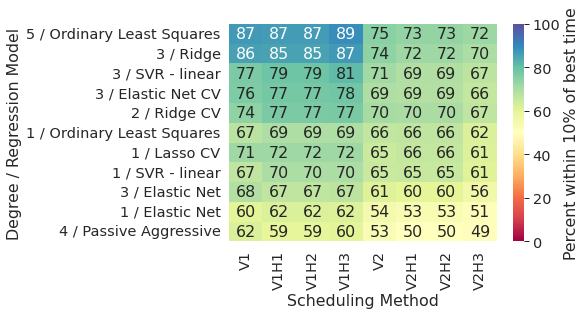

In [29]:
# normalize
total = 50_000
tmp = regModelMethodScores10PDF.transform(lambda x: 100 * x / total)
#
aspect = 5 / 8
width = 8
#plt.figure(figsize=(width,width*aspect))
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScores10PDF.columns],
                 cbar_kws={"label": "Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmap10P", bbox_inches="tight")
plt.show()

In [30]:
regModelMethodDiffsDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodDiffs.items():
    rM, meth = rm
    regModelMethodDiffsDF.loc[rM, meth] = s

In [31]:
regModelMethodDiffsDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,2.3965e+08,2.7593e+08,2.7593e+08,2.3164e+08,6.6333e+08,5.7857e+08,5.7857e+08,6.1306e+08
3 / Ridge,2.6382e+08,3.0214e+08,3.0214e+08,2.7633e+08,6.9238e+08,5.9636e+08,5.9636e+08,6.5229e+08
3 / SVR - linear,3.7813e+08,3.8018e+08,3.8018e+08,3.4609e+08,7.2483e+08,6.3134e+08,6.3134e+08,6.8597e+08
3 / Elastic Net CV,3.7100e+08,3.9290e+08,3.9290e+08,3.8251e+08,7.4505e+08,5.8901e+08,5.8901e+08,6.6543e+08
2 / Ridge CV,4.1547e+08,4.0576e+08,4.0576e+08,4.0327e+08,7.6519e+08,5.9811e+08,5.9811e+08,6.7828e+08
1 / Ordinary Least Squares,4.7633e+08,4.7585e+08,4.7585e+08,4.7248e+08,8.3087e+08,6.1528e+08,6.1528e+08,7.0887e+08
1 / Lasso CV,4.3125e+08,4.6967e+08,4.6967e+08,4.6468e+08,8.2630e+08,6.0997e+08,6.0997e+08,6.9763e+08
1 / SVR - linear,4.6586e+08,4.6263e+08,4.6263e+08,4.5944e+08,8.1655e+08,6.1574e+08,6.1574e+08,7.0690e+08
3 / Elastic Net,4.2554e+08,4.9394e+08,4.9394e+08,4.8763e+08,8.5908e+08,6.8734e+08,6.8734e+08,7.8869e+08
1 / Elastic Net,5.8913e+08,6.2854e+08,6.2854e+08,6.2123e+08,9.4519e+08,8.2115e+08,8.2115e+08,8.8593e+08


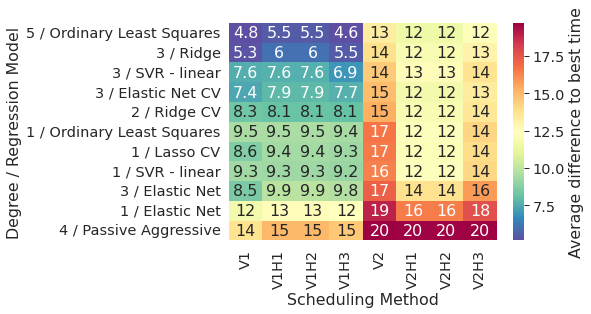

In [32]:
# normalize
total = 50_000
tmp = regModelMethodDiffsDF.transform(lambda x: x / total / 1000)
#
#plt.figure(figsize=(8,5))
ax = sns.heatmap(tmp,
                 cmap=sns.color_palette("Spectral", as_cmap=True).reversed(),
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodDiffsDF.columns],
                 cbar_kws={"label": "Average difference to best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
#ax.set_yticklabels(ax.get_yticklabels(),rotation=45, va="top")
#plt.yticks(rotation=45)
#ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "heatmapDiff", bbox_inches="tight")
plt.show()

------

In [33]:
#tmp = cvBigtable[cvBigtable.regModel != "N/A"]
#clusters = tmp.cluster.unique()
regModels = ['1 / SVR - rbf', '1 / Stochastic Gradient Descent', '3 / SVR - rbf']  #tmp.regModel.unique()
#methods = tmp.method.unique()
#del tmp

In [34]:
confs = dict()
with open("percentileCVModels", "r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l: PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle", fName.strip())
            key = f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"
            p = confs.get(key, list())
            confs[key] = p + [commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])]
for k, l in confs.items():
    confs[k] = commons.jamGeomean(l)


In [35]:
pprint(confs)

{
│   '1 / SVR - rbf': 0.8387889322997693,
│   '1 / Stochastic Gradient Descent': 0.7855591233166146,
│   '3 / SVR - rbf': 0.46743515455075557
}

In [36]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [37]:
pprint(regModels)

['1 / SVR - rbf', '1 / Stochastic Gradient Descent', '3 / SVR - rbf']

In [38]:
cvScores = dict()
cv10PScores = dict()
cvDiffs = dict()
j = 1
for i in itertools.product(wfNames, wfNames):  #,d in cvBigtable[cvBigtable.regModel != "N/A"].groupby(["cvSplit","ukSplit"]):
    if i[0] == i[1]:
        continue
    rc.log(j, i)
    cvScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores_CV-{i[0]}_U-{i[1]}.pickle",
                                          None  #d.drop(["cvSplit","ukSplit"], axis=1)
                                          )
    cv10PScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores10P_CV-{i[0]}_U-{i[1]}.pickle",
                                             None,  #d.drop(["cvSplit","ukSplit"], axis=1),
                                             tol=lambda cur, mini: 10 * mini / 100)
    cvDiffs[i] = getRegModelMethodScores(f"cvRegModelMethodDiffs_CV-{i[0]}_U-{i[1]}.pickle",
                                         None,  #d.drop(["cvSplit","ukSplit"], axis=1), crit=lambda a, b, c: True, scorer=lambda cur, mini, tol: abs(cur - mini)
                                         )
    j += 1

[17:43:23] 1                                                                  ]8;id=584816;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('sarek', 'methylseq')

           2                                                                  ]8;id=178107;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('sarek', 'chipseq')

           3                                                                  ]8;id=342689;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('sarek', 'eager')

           4                                                                  ]8;id=342832;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('sarek', 'viralrecon')

           5                                                                  ]8;id=426931;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('methylseq', 'sarek')

           6                                                                  ]8;id=620216;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('methylseq', 'chipseq')

           7                                                                  ]8;id=580023;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('methylseq', 'eager')

           8                                                                  ]8;id=665583;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('methylseq', 'viralrecon')

           9                                                                  ]8;id=596953;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('chipseq', 'sarek')

           10                                                                 ]8;id=154168;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('chipseq', 'methylseq')

           11                                                                 ]8;id=545397;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('chipseq', 'eager')

           12                                                                 ]8;id=644903;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('chipseq', 'viralrecon')

           13                                                                 ]8;id=486849;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('eager', 'sarek')

           14                                                                 ]8;id=475290;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('eager', 'methylseq')

           15                                                                 ]8;id=326444;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('eager', 'chipseq')

           16                                                                 ]8;id=598807;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('eager', 'viralrecon')

           17                                                                 ]8;id=948018;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('viralrecon', 'sarek')

           18                                                                 ]8;id=770142;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('viralrecon', 'methylseq')

           19                                                                 ]8;id=583611;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('viralrecon', 'chipseq')

           20                                                                 ]8;id=327678;file:///tmp/ipykernel_5697/3180652875.py\3180652875.py]8;;\:8
           ('viralrecon', 'eager')

In [39]:
cvScores

{
│   ('sarek', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 11027,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 11552,
│   │   ... +22
│   },
│   ('sarek', 'chipseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 9723,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 10618,
│   │   ... +22
│   },
│   ... +18
}

In [40]:
cv10PScores

{
│   ('sarek', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 33536,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 34696,
│   │   ... +22
│   },
│   ('sarek', 'chipseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 36016,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 36726,
│   │   ... +22
│   },
│   ... +18
}

In [41]:
cvDiffs

{
│   ('sarek', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 407246972.25908804,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 410611975.8017383,
│   │   ... +22
│   },
│   ('sarek', 'chipseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 390776006.0008152,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 401540936.6052478,
│   │   ... +22
│   },
│   ... +18
}

In [42]:
cvRegModelMethodScores = dict()
for _, sc in cvScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores[rmmeth] = cvRegModelMethodScores.get(rmmeth, 0) + r

In [43]:
cvRegModelMethodScores10P = dict()
for _, sc in cv10PScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores10P[rmmeth] = cvRegModelMethodScores10P.get(rmmeth, 0) + r

In [44]:
cvRegModelMethodDiffs = dict()
for _, sc in cvDiffs.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodDiffs[rmmeth] = cvRegModelMethodDiffs.get(rmmeth, 0) + r

In [45]:
cvRegModelMethodScores

{
│   ('1 / SVR - rbf', 'recommenderV1'): 259713,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 275020,
│   ... +22
}

In [46]:
cvRegModelMethodScores10P

{
│   ('1 / SVR - rbf', 'recommenderV1'): 759588,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 765871,
│   ... +22
}

In [47]:
cvRegModelMethodDiffs

{
│   ('1 / SVR - rbf', 'recommenderV1'): 7180676740.188436,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 7635328122.482502,
│   ... +22
}

In [48]:
cvRegModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores.items():
    rM, meth = rm
    cvRegModelMethodScoresDF.loc[rM, meth] = s

In [49]:
cvRegModelMethodScoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,259713.0,275020.0,275020.0,290446.0,198989.0,218629.0,218629.0,205442.0
1 / Stochastic Gradient Descent,197793.0,199337.0,199337.0,197955.0,170579.0,186399.0,186399.0,175455.0
3 / SVR - rbf,197748.0,196185.0,196185.0,208983.0,111865.0,120898.0,120898.0,117597.0


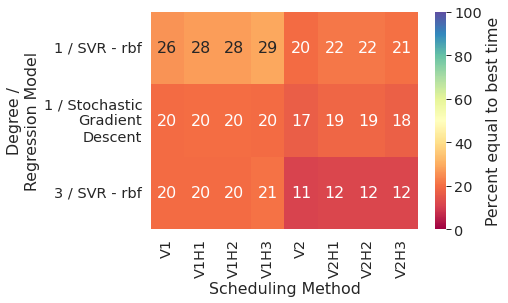

In [50]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodScoresDF.transform(lambda x: 100 * x / total)
#
#plt.figure(figsize=(7,3))
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScoresDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /\nRegression Model")
ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "cvHeatmapBIS", bbox_inches="tight")
plt.show()

In [51]:
cvRegModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores10P.items():
    rM, meth = rm
    cvRegModelMethodScores10PDF.loc[rM, meth] = s

In [52]:
cvRegModelMethodScores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,759588.0,765871.0,765871.0,778016.0,687719.0,683672.0,683672.0,646950.0
1 / Stochastic Gradient Descent,708525.0,722652.0,722652.0,724040.0,656117.0,677033.0,677033.0,631148.0
3 / SVR - rbf,656111.0,650994.0,650994.0,658911.0,550538.0,529632.0,529632.0,516272.0


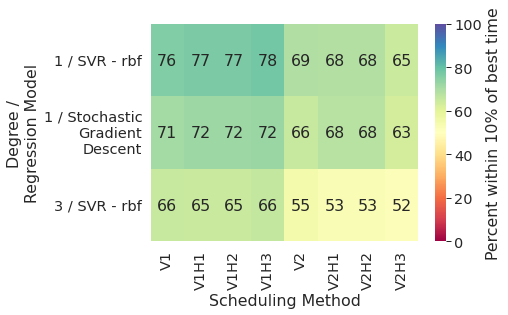

In [53]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodScores10PDF.transform(lambda x: 100 * x / total)
#
#plt.figure(figsize=(5.5,2.2))
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScores10PDF.columns],
                 cbar_kws={"label": "Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /\nRegression Model")
ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "cvHeatmap10P", bbox_inches="tight")
plt.show()

In [54]:
cvRegModelMethodDiffsDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodDiffs.items():
    rM, meth = rm
    cvRegModelMethodDiffsDF.loc[rM, meth] = s

In [55]:
cvRegModelMethodDiffsDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,7.1807e+09,7.6353e+09,7.6353e+09,7.2267e+09,1.4852e+10,1.1874e+10,1.1874e+10,1.3449e+10
1 / Stochastic Gradient Descent,8.5111e+09,8.8966e+09,8.8966e+09,8.8098e+09,1.5957e+10,1.1449e+10,1.1449e+10,1.3356e+10
3 / SVR - rbf,9.6830e+09,1.0857e+10,1.0857e+10,1.0402e+10,1.9888e+10,1.9704e+10,1.9704e+10,2.0392e+10


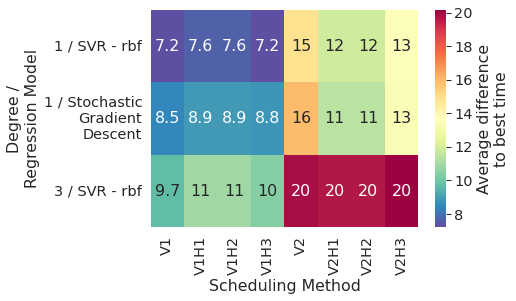

In [56]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodDiffsDF.transform(lambda x: x / total / 1000)
#
#plt.figure(figsize=(13.5,2))
ax = sns.heatmap(tmp,
                 cmap=sns.color_palette("Spectral", as_cmap=True).reversed(),
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodDiffsDF.columns],
                 cbar_kws={"label": "Average difference\nto best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /\nRegression Model")
ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "cvHeatmapDiff", bbox_inches="tight")
plt.show()

------

In [57]:
def compareCVFull(fullTable, cvSplitTable, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(res, cvres, tol):
            dist = abs(res - cvres)
            if dist <= tol:
                dec = 0
            elif res < cvres:
                dec = -1
            else:
                dec = 1
            return dec

        crit = yep
    if scorer is None:
        def sc(res, cvres, tol):
            return 1

        scorer = sc
    #
    totalTable = fullTable.join(cvSplitTable.set_index(["cluster", "wfName"]), on=["cluster", "wfName"], rsuffix="_cv")
    #
    clWFCombs = itertools.product(clusters, wfNames)
    numclWFCombs = len(list(clWFCombs))
    #
    comp = dict(full=0, equal=0, cv=0)
    with commons.stdProgress(rc) as prog:
        cvwfProg = prog.add_task("Comparing", total=numclWFCombs)

        for row in totalTable.itertuples():
            if type(tol) is int or type(tol) is float:
                t = tol
            else:
                t = tol(row.res, row.res_cv)
            dec = crit(row.res, row.res_cv, t)
            if dec == -1:
                key = "full"
            elif dec == 0:
                key = "equal"
            elif dec == 1:
                key = "cv"
            else:
                raise Exception("crit must return -1, 0, or 1")

            comp[key] = comp[key] + scorer(row.res, row.res_cv, t)
            prog.advance(cvwfProg)
    return comp

In [58]:
maxi = regModelMethodScoresDF.max().max()
cand = regModelMethodScoresDF.idxmax().reset_index()
cand.columns = ["method", "model"]
bisRmmeth = None
for i in cand.itertuples():
    if regModelMethodScoresDF.loc[i.model, i.method] == maxi:
        bisRmmeth = (i.model, i.method)
        break
bisRmmeth

(
│   '5 / Ordinary Least Squares',
│   'recommenderV1H3'
)

In [59]:
if Path("bisBigtable.pickle").is_file():
    with open("bisBigtable.pickle", "br") as f:
        bisBigtable = pickle.load(f)
else:
    bisBigtable = bigtable.query("regModel==@bisRmmeth[0] and method==@bisRmmeth[1]")
    #bisBigtable.drop(["regModel", "method", "cvSplit", "ukSplit", "clusterSize"], axis=1)
    with open("bisBigtable.pickle", "bw") as f:
        bisBigtable = pickle.dump(bisBigtable, f)
bisBigtable

,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit
400003,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33364.6500,None,None
400011,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39318.6000,None,None
400019,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,126638.2667,None,None
400027,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,27151.2000,None,None
400035,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,138079.2667,None,None
...,...,...,...,...,...,...,...,...
799963,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,sarek,recommenderV1H3,33356.3500,None,None
799971,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,methylseq,recommenderV1H3,39318.6000,None,None
799979,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,chipseq,recommenderV1H3,126735.6333,None,None
799987,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,eager,recommenderV1H3,27574.6000,None,None


In [60]:
maxi = cvRegModelMethodScoresDF.max().max()
cand = cvRegModelMethodScoresDF.idxmax().reset_index()
cand.columns = ["method", "model"]
bisCVRmmeth = None
for i in cand.itertuples():
    if cvRegModelMethodScoresDF.loc[i.model, i.method] == maxi:
        bisCVRmmeth = (i.model, i.method)
        break
bisCVRmmeth

(
│   '1 / SVR - rbf',
│   'recommenderV1H3'
)

In [61]:
if Path("bisCVBigtable.pickle").is_file():
    with open("bisCVBigtable.pickle", "br") as f:
        bisCVBigtable = pickle.load(f)
else:
    bisCVBigtable = cvBigtable.query("regModel==@bisCVRmmeth[0] and method==@bisCVRmmeth[1]")
    #bisCVBigtable.drop(["regModel", "method", "clusterSize"], axis=1)
    with open("bisCVBigtable.pickle", "bw") as f:
        pickle.dump(bisCVBigtable, f)
bisCVBigtable

,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit
400003,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33866.6667,viralrecon,eager
400011,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39914.7333,viralrecon,eager
400019,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,136622.2000,viralrecon,eager
400027,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,28006.6000,viralrecon,eager
400035,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,150695.5333,viralrecon,eager
...,...,...,...,...,...,...,...,...
20399963,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,sarek,recommenderV1H3,44115.8500,chipseq,eager
20399971,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,methylseq,recommenderV1H3,44736.2667,chipseq,eager
20399979,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,chipseq,recommenderV1H3,184831.8333,chipseq,eager
20399987,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,eager,recommenderV1H3,38532.4000,chipseq,eager


------------

In [62]:
def comparePerWFCVFull(fullTable, cvSplitTable, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(res, cvres, tol):
            return abs(res - cvres) <= tol

        crit = yep
    if scorer is None:
        def sc(res, cvres, tol):
            return 1

        scorer = sc
    #
    out = dict()
    for wf, fD in fullTable.groupby(["wfName"]):
        out[wf] = dict()
        #
        totalTable = fD.join(cvSplitTable[cvSplitTable.wfName == wf].set_index(["cluster"]), on=["cluster"], rsuffix="_cv")
        totalTable["diff"] = totalTable["res_cv"] - totalTable["res"]
        out[wf] = totalTable["diff"].sum()
    return out

In [63]:
fileLoc = Path("compPerWFCV_BISFull.pickle")
if fileLoc.is_file():
    with open(fileLoc, "br") as f:
        comp = pickle.load(f)
else:
    comp = dict()
    for rmmeth, rmD in cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "method"]):
        rc.log(rmmeth)
        comp[rmmeth] = dict()
        for split, spD in rmD.groupby(["cvSplit", "ukSplit"]):
            rc.log(split)
            comp[rmmeth][split] = comparePerWFCVFull(bisBigtable, spD)
    with open(fileLoc, "bw") as f:
        pickle.dump(comp, f)

In [64]:
comp

{
│   ('1 / SVR - rbf', 'recommenderV1'): {
│   │   ('chipseq', 'eager'): {
│   │   │   'chipseq': 42772738.31666661,
│   │   │   'eager': 1402918.9000000018,
│   │   │   ... +3
│   │   },
│   │   ('chipseq', 'methylseq'): {
│   │   │   'chipseq': 4829322.7499999525,
│   │   │   'eager': 2881106.4000000004,
│   │   │   ... +3
│   │   },
│   │   ... +18
│   },
│   ('1 / SVR - rbf', 'recommenderV1H1'): {
│   │   ('chipseq', 'eager'): {
│   │   │   'chipseq': 118023545.29999995,
│   │   │   'eager': 4480675.500000001,
│   │   │   ... +3
│   │   },
│   │   ('chipseq', 'methylseq'): {
│   │   │   'chipseq': 83270381.29999995,
│   │   │   'eager': 4490550.9,
│   │   │   ... +3
│   │   },
│   │   ... +18
│   },
│   ... +22
}

In [65]:
col = list()
for rmmeth, d1 in comp.items():
    rm, meth = rmmeth
    for cvuk, d2 in d1.items():
        cv, uk = cvuk
        for wf, d3 in d2.items():
            #rc.log([rm, meth, cv, uk, wf, d3])
            col.append([rm, meth, cv, uk, wf, d3])
compDF = pds.DataFrame(data=col, columns=["regModel", "method", "cvSplit", "ukSplit", "wfName", "sumDiff"])


In [66]:
order = ["eager", "methylseq", "sarek", "viralrecon", "chipseq"]
compDF["wfName"] = pds.Categorical(compDF["wfName"], categories=order, ordered=True)
compDF["cvSplit"] = pds.Categorical(compDF["cvSplit"], categories=order, ordered=True)
compDF["ukSplit"] = pds.Categorical(compDF["ukSplit"], categories=order, ordered=True)

In [67]:
compDF = compDF.sort_values(["ukSplit","cvSplit"])

In [68]:
compDF["avgDiff"] = compDF["sumDiff"] / 10000

In [69]:
compDF["secDiff"] = compDF["avgDiff"] / 1000

In [70]:
compDF

,regModel,method,cvSplit,ukSplit,wfName,sumDiff,avgDiff,secDiff
45,1 / SVR - rbf,recommenderV1,methylseq,eager,chipseq,-4.9191e+07,-4919.0719,-4.9191
46,1 / SVR - rbf,recommenderV1,methylseq,eager,eager,1.2725e+07,1272.4771,1.2725
47,1 / SVR - rbf,recommenderV1,methylseq,eager,methylseq,9.2616e+06,926.1593,0.9262
48,1 / SVR - rbf,recommenderV1,methylseq,eager,sarek,5.9352e+06,593.5201,0.5935
49,1 / SVR - rbf,recommenderV1,methylseq,eager,viralrecon,1.3862e+08,13862.1251,13.8621
...,...,...,...,...,...,...,...,...
2380,3 / SVR - rbf,recommenderV2H3,viralrecon,chipseq,chipseq,5.5165e+08,55164.7621,55.1648
2381,3 / SVR - rbf,recommenderV2H3,viralrecon,chipseq,eager,-1.4097e+06,-140.9728,-0.1410
2382,3 / SVR - rbf,recommenderV2H3,viralrecon,chipseq,methylseq,2.5245e+06,252.4540,0.2525
2383,3 / SVR - rbf,recommenderV2H3,viralrecon,chipseq,sarek,4.1984e+07,4198.3542,4.1984


In [71]:
test = compDF.query("regModel=='1 / SVR - rbf' and method=='recommenderV1H3'").drop(["regModel", "method"], axis=1)

In [72]:
test

,cvSplit,ukSplit,wfName,sumDiff,avgDiff,secDiff
345,methylseq,eager,chipseq,4.8517e+07,4851.6775,4.8517
346,methylseq,eager,eager,1.4328e+07,1432.8454,1.4328
347,methylseq,eager,methylseq,9.2616e+06,926.1593,0.9262
348,methylseq,eager,sarek,3.2424e+06,324.2357,0.3242
349,methylseq,eager,viralrecon,3.5815e+07,3581.4523,3.5815
365,sarek,eager,chipseq,1.1181e+08,11180.7178,11.1807
366,sarek,eager,eager,1.1574e+07,1157.4070,1.1574
367,sarek,eager,methylseq,6.5884e+06,658.8418,0.6588
368,sarek,eager,sarek,1.7881e+07,1788.1465,1.7881
369,sarek,eager,viralrecon,3.9430e+07,3943.0413,3.9430


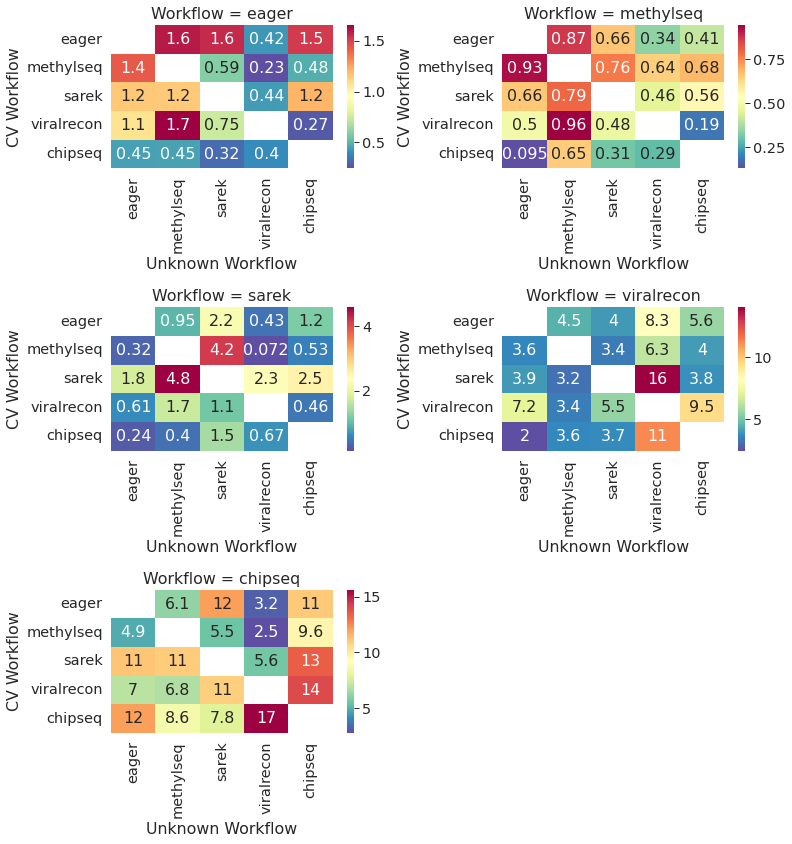

In [73]:
order = ["eager", "methylseq", "sarek", "viralrecon", "chipseq"]
g = sns.FacetGrid(test, col="wfName",
                  col_wrap=2,
                  sharex=False,
                  sharey=False,
                  col_order=order,
                  height=4,
                  aspect=1.4
                  )


def draw_heatmap(*args, **kwargs):
    data = kwargs.pop("data")
    d = data.pivot("cvSplit", "ukSplit", "secDiff")
    ax = sns.heatmap(d,
                cmap=sns.color_palette("Spectral", as_cmap=True).reversed(),
                #cbar_kws={"label": "Average difference to best time"},
                robust=True,
                annot=True,
                **kwargs)
    ax.set_xlabel("Unknown Workflow")
    ax.set_ylabel("CV Workflow")
    #ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
g.map_dataframe(draw_heatmap)
g.set_titles("Workflow = {col_name}")
save_plot(g, "comp_BISCV_BISFull_PerWF")

In [ ]:
test.query("ukSplit==wfName or cvSplit==wfName")

------------

In [ ]:
bisBigtable: pds.DataFrame
bisBigtable = bisBigtable.fillna("N/A")
bisBigtable

In [ ]:
bisCVBigtable: pds.DataFrame
test = bisCVBigtable
test["split"] = test["cvSplit"] + " / " + test["ukSplit"]
test

In [ ]:
g = sns.catplot(kind="point",
                data=test,
                x="clusterSize",
                y="res",
                aspect=1.5,
                height=8,
                ci=None,
                hue="split")
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="CV/Unknown-Split", frameon=False)
g.set(xlabel="Cluster Size", ylabel="Runtimes")
save_plot(g, "compCV")
plt.show()

-------------

In [ ]:
bisCVBigtable["isUk"] = bisCVBigtable.wfName == bisCVBigtable.ukSplit

-------------

In [ ]:
t = test.groupby(["wfName", "cluster"])["res"].aggregate(statistics.mean)

In [ ]:
c = test[["regModel", "cluster", "clusterSize", "wfName", "method", "cvSplit", "ukSplit", "split"]].join(t, on=["wfName", "cluster"])
c

In [ ]:
c = c[c.split == "viralrecon / eager"]
c["Kind"] = "Average CV"
c["Type"] = "Average CV"
c

In [ ]:
bisBigtable["Kind"] = "Full"
bisBigtable["Type"] = "Full"

In [ ]:
randomDF: pds.DataFrame = bigtable[bigtable.regModel == "N/A"]
randomDF.append(cvBigtable[cvBigtable.regModel == "N/A"])
randomDF["Kind"] = randomDF["method"].transform(lambda x: x.replace("V1", ""))
randomDF = randomDF.query('Kind == "randomAvg" or  Kind == "randomP0" or Kind == "randomP10" or Kind == "randomP20" or Kind == "randomP30"')
randomDF["Type"] = "Random"
randomDF

In [ ]:
data = c.append(bisBigtable)
data = data.append(randomDF)
data = data.drop(["cvSplit", "ukSplit", "split"], axis=1)
data.reset_index(drop=True, inplace=True)
data

In [ ]:
g: sns.FacetGrid = sns.relplot(kind="line",
                               data=data,
                               x="clusterSize",
                               y="res",
                               ci=None,
                               style="Type",
                               markers=["o", "^", "s"],
                               dashes=False,
                               hue="Kind",
                               aspect=1.5,
                               height=8,
                               lw=2,
                               ms=10,
                               )
#sns.move_legend(g, "center left", bbox_to_anchor=(0.82,0.5))#, markerscale=20)
#plt.setp(g.ax.get_legend(), markerscale=2)
#g = g.add_legend(markerscale=2)
g.set(xlabel="Cluster Size", ylabel="Runtimes")
g.ax.set_xticks(range(2, 21))
save_plot(g, "compCVFullRandom")
plt.show()

# [END] trying out new visualisation

In [ ]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
g.set(xlabel="Runtimes", ylabel="Strategy")
save_plot(g, f"res_Vs_method_{style}.plot")
plt.show()

In [ ]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
save_plot(g, f"res_Vs_regModel_{style}.plot")
plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
g.set_titles("Workflow: {col_name}")
save_plot(g, f"res_Vs_method_perWF_{style}.plot")
plt.show()

# Filter for only the BiS regression model:

In [ ]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [ ]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
g.set(xlabel="Runtimes", ylabel="Strategy")
g.set_titles("Workflow: {col_name}")
save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()



In [ ]:
wfNames = cvBigtable.wfName.unique()

In [ ]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [ ]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [ ]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
g.set(xlabel="Runtimes", ylabel="Strategy")
save_plot(g, f"res_Vs_method_{style}.plot")
plt.show()

In [ ]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
g.set_titles("Workflow: {col_name}")
save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
plt.show()

# Filter for only the BiS regression model:

In [ ]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [ ]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
g.set(xlabel="Runtimes", ylabel="Strategy")
g.set_titles("Workflow: {col_name}")
save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
